# **Deliverable 2: X-ray Imaging and Computed Tomography (CT)**

---

## Overview

This deliverable covers key concepts from **Lectures 13–18** (Weeks 6–7) of the course. You will explore:

- X-ray tube design and production
- Projection radiography geometry, contrast, and scatter reduction
- Digital X-ray detectors and image formation
- CT acquisition, reconstruction, image quality, and dose metrics
- Protocol design and optimization for clinical goals

You will engage with the material through conceptual questions, coding exercises, error analysis, and a design challenge. By the end of this deliverable, you will be able to analyze and simulate X-ray and CT imaging systems, interpret image quality trade-offs, optimize protocols, and apply quantitative reasoning to real-world clinical scenarios.

---

## Part 1: X-ray Production and Spectrum



### Key Concepts

- **X-ray Tube Physics:** X-rays are produced when high-speed electrons strike a metal target (anode), resulting in rapid deceleration (bremsstrahlung) and ejection of inner-shell electrons (characteristic X-rays). The output spectrum is a combination of continuous (bremsstrahlung) and discrete (characteristic) peaks.
- **Tube Voltage (kVp):** Sets the maximum photon energy; higher kVp increases beam penetration but reduces contrast.
- **Tube Current (mA):** Controls the number of electrons (and thus photons) produced per second; affects image brightness and patient dose.
- **Filtration:** Removes low-energy photons (which contribute to dose but not image quality), resulting in a "harder" (higher average energy) spectrum. The filtered spectrum $I(E)$ is zero for $E < E_{filter}$.
- **Anode Material:** Determines the energy of characteristic peaks (e.g., tungsten anode: 59 and 67 keV).


### 1.1 X-ray Tube Design Scenario

You are tasked with designing an X-ray tube for a pediatric chest radiography system. The goal is to minimize patient dose while maintaining diagnostic image quality.


### **Question 1**

- a)  Explain the roles of tube voltage (kVp) and tube current (mA) in shaping the X-ray spectrum and affecting patient dose.

    Tube voltage (kVp) determines the nature of the spectrum, including which (if any) characteristic peaks occur as well as the overall energy of the produced X-rays. 
    Most of the energy content in a beam of X-rays comes from bremsstrahlung at an energy approximately one-third of the tube voltage; in addition, tube voltages above the electron shell binding energies allow characteristic X-rays to be produced. 
    Higher-energy photons have smaller photoelectric cross-sections and so will petetrate better (helping reduce noise), but also have larger Compton cross-sections and so will reduce the image contrast.
    Different tube voltages can also be used for various dual-energy types of imaging; adjusting the photon energies to be just above and just below a K-edge in the patient or contrast agent can allow for isolation of different features.

    Tube current (mA), meanwhile, affects the number of photons produced. In general, this relationship is proportional, meaning that higher tube currents result in higher dosages and vice versa. Since the SNR of a quantum-limited imaging system is proportional to the square root of the number of detected photons, increasing tube current will allow for brighter and less noisy images at the cost of this reduced dose.

- b) Describe how filtration and the choice of anode material influence the X-ray spectrum and image quality.

    Filtration, or 'hardening', of the beam before it reaches the patient allows for low-energy photons which contribute to dose but are highly likely to be absorbed (due to a large cross-section) before reaching the detector regardless of their path (i.e. they do not contribute to the image contrast) to be removed. This produces a low-end cutoff of the X-ray spectrum. It very slightly degrades image quality (requiring a small increase in tube current to compensate), but reduces the dose received by the patient even considering this required increase in tube current.

- c) Propose a set of tube parameters (kVp, mA, filtration) for pediatric imaging and justify your choices based on physical principles.

    Children are more susceptible to radiation dose than adults, and so dosage considerations are especially important. For chest radiography in particular, the air in the lungs has significantly less attenuation than the mediastinum and bone surrounding it, which means that the photoelectric effect will produce more image contrast, and thus that we can use higher tube voltage and lower tube current to reduce the dose. For the same reason, we should use a filter to harden the beam and further reduce the dose.

    







### **Coding Exercise 1**

1. Implement a function `simulate_xray_spectrum(kvp, e_filter)` that returns the energy (keV) and relative intensity arrays.
2. Plot the spectrum for kVp = 80, 100, 120 keV and E_filter = 30 keV.

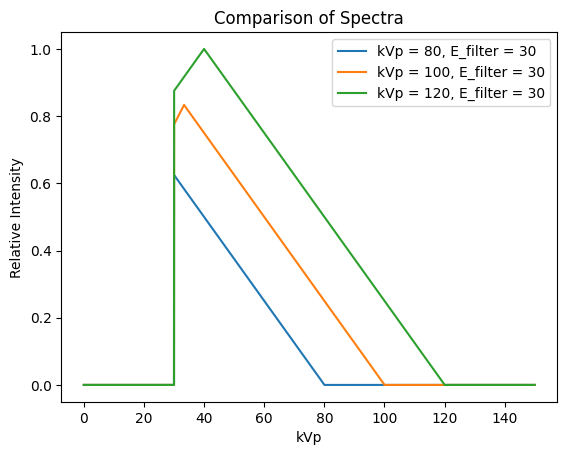

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_xray_spectrum(kvp, e_filter):
    energies = np.arange(0, 150, 0.01)
    
    # Simple model: roughly linear (ideal) bremsstrahlung spectrum, hard cutoff, peak at 1/3 the kVp
    bremsstrahlung_peak_energy = kvp / 3
    relative_intensities = (kvp - energies) / 80
        # 80 is the maximum value for kVp = 120 keV, so make the relative intensities stem from that

    for i, intensity in enumerate(relative_intensities):
        if energies[i] <= e_filter:
            relative_intensities[i] = 0
        elif intensity < 0:
            relative_intensities[i] = 0
        elif energies[i] < bremsstrahlung_peak_energy:
            # Simple linear model: increase output from 0 linearly up to the bremsstrahlung peak
            relative_intensities[i] =  relative_intensities[i] - (1 - energies[i] / bremsstrahlung_peak_energy)

    return relative_intensities


# TODO: Simulate the X-ray spectrum
kvps = [80, 100, 120]
e_filters = [30]
legend = []

# TODO: Plot the spectrum for different kVp and E_filter values
for energy in kvps:
    for filter in e_filters:
        plt.plot(np.arange(0, 150, 0.01), simulate_xray_spectrum(energy, filter))
        legend.append(f"kVp = {energy}, E_filter = {filter}")
plt.legend(legend)
plt.xlabel("kVp"); plt.ylabel("Relative Intensity"); plt.title("Comparison of Spectra")
plt.show()

# TODO: Analyze and discuss the results
'''
As we can see, implementing beam hardening cuts off the low end of the intensity spectrum. This may be before or after the natural peak 
of the bremsstrahlung spectrum (which is at approximately one-third of kVp).
It is important to note that we cannot produce an ideal filter this way; in reality, beam hardening is based on exponential attenuation,
with the attenuation coefficient mu decreasing with beam frequency; thus, some low-frequency photons will make it through and some
high-frequency photons will be attenuated, making the overall spectrum much more curved rather than straight.
'''
pass

---

## Part 2: CT Simulation, Error Analysis & Design

### Key Concepts

- Shepp-Logan Phantom: A digital test object for CT simulation.
- Sinogram: 2D plot of projection data as a function of angle and position.
- Image Reconstruction: Filtered backprojection and iterative methods.
- Error Analysis: Identifying and quantifying sources of error/artifacts in CT reconstruction.
- Design & Optimization: Creating and optimizing CT protocols for specific clinical goals.


### 2.1 Shepp-Logan Phantom and Sinogram

### **Coding Exercise 2**

- a) Generate a Shepp-Logan digital phantom in Python (use `skimage.data.shepp_logan_phantom` or custom code).
- b) Simulate CT projections (sinogram) of the phantom using the Radon transform.
- c) Reconstruct the image from the sinogram using filtered backprojection.


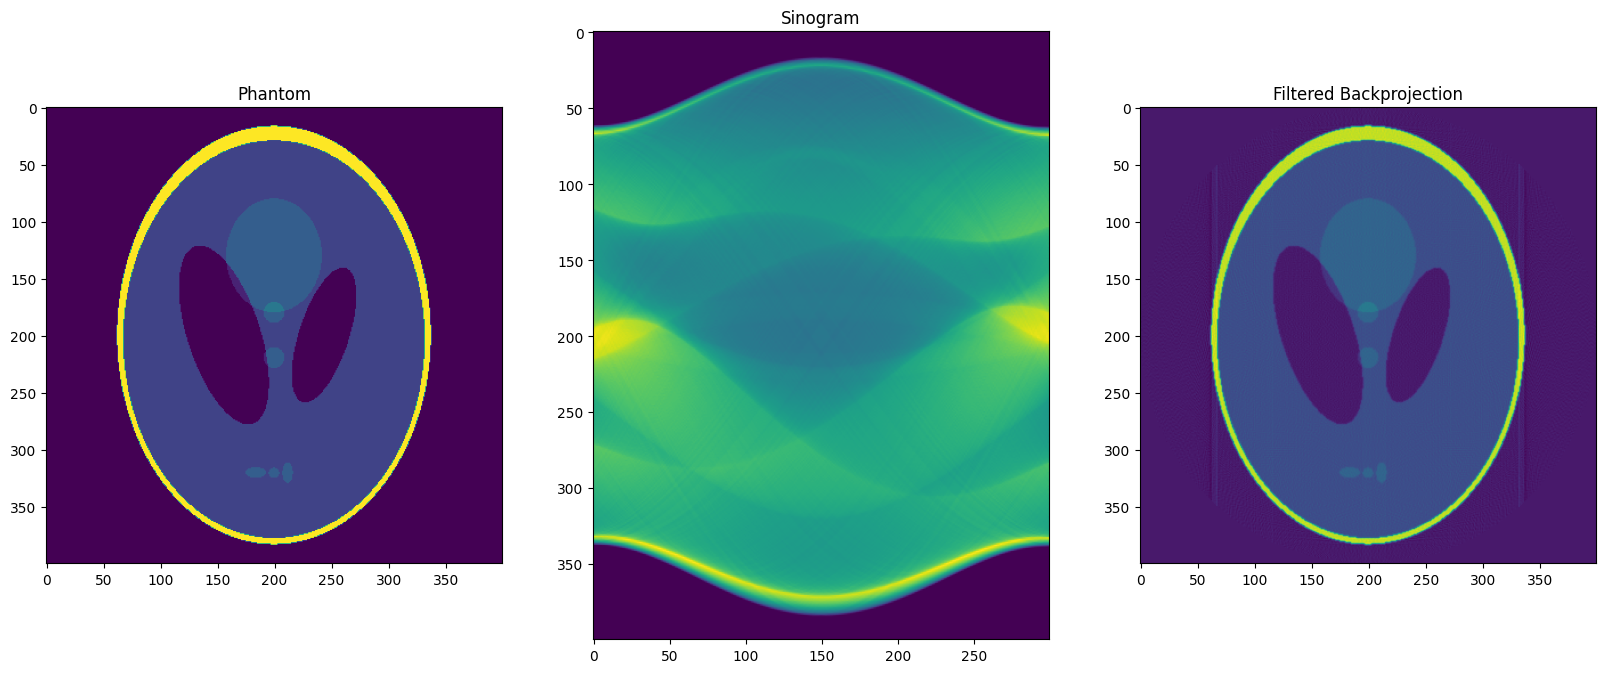

In [3]:
# TODO: Generate a Shepp-Logan phantom
# %pip install scikit-image
from skimage.data import shepp_logan_phantom
phantom = shepp_logan_phantom()

# TODO: Simulate CT projections (sinogram) using the Radon transform
from skimage.transform import radon, iradon
sinogram = radon(phantom, theta=np.linspace(0.0, 180.0, 300))

# TODO: Reconstruct the image from the sinogram
reconstruction = iradon(sinogram, theta=np.linspace(0.0, 180.0, 300), filter_name='ramp')

# TODO: Visualize the phantom, sinogram, and reconstruction
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,20))
ax1.imshow(phantom); ax1.set_title("Phantom")
ax2.imshow(sinogram); ax2.set_title("Sinogram")
ax3.imshow(reconstruction); ax3.set_title("Filtered Backprojection")
plt.show()


### 2.2 Error Analysis


### **Question 2**

- a) Identify and describe at least one source of error or artifact in your reconstructed image (e.g., limited projections, noise, motion, beam hardening).

    One observable artifact in the reconstructed image is the vertical 'streaks' tangent to the left and right sides of the large oval shape in the Shepp-Logan phantom. These streaks may be a result of photon starvation from the edge of the phantom, which has strong photon absorption. Because they are strictly vertical and located on the outside of the phantom, however, they can be mitigated by adding additional projections per degree so that the backprojection can more easily interpolate in those regions. This is not always possible for photon starvation, however; in real imaging, it may be necessary to increase penetration by increasing the kV of the tube output.

- b) Quantify the impact of one error (e.g., measure reconstruction error as projections are reduced or noise is increased).

    Reducing the number of projections decreases the effectiveness of reconstruction, as high-spatial-frequency parts of the image begin to alias and produce artifacts. In Coding Exercise 3, I calculated the Root Mean Square Error of the filtered backprojection method for four different numbers of projections (30, 100, 300, and 1000). While, as expected, the RMSE decreases as the number of projections increase from 30 to 300, removing aliasing artifacts from the image, I also observed that the RMSE does not strictly decrease with the number of samples; in fact, the 1000-sample reonstruction had more root-mean-square error than the 300-sample reconstruction! This is actually a known consequence of oversampling in medical imaging; it is caused by a phenomenon kown as the Gibbs effect, where discontinuities (in this case, sharp edges such as those seen on the edges of the Shepp-Logan phantom) in a spatial-domain signal introduce oscillations in its finitely-truncated Fourier series reconstruction, contributing to root-mean-square error.

- c) Propose and implement a method to mitigate one artifact or error, and evaluate its effectiveness.
    
    Despite the increase in RMSE from oversampling, I believe the error introduced by increasing the number of projections should be relatively small in amplitude; thus, I propose that increasing the number of projections in the sinogram should eliminate the streaking artifacts in this case. I will implement this in Coding Exercise 3.

### **Coding Exercise 3**

Implement your method to mitigate an artifact or error and evaluate its effectiveness.

Root Mean Square Error (30 Samples):  0.004100126715358454
Root Mean Square Error (100 Samples):  0.001701164033870524
Root Mean Square Error (300 Samples):  0.0013194567934771283
Root Mean Square Error (1000 Samples):  0.0015601597500249482


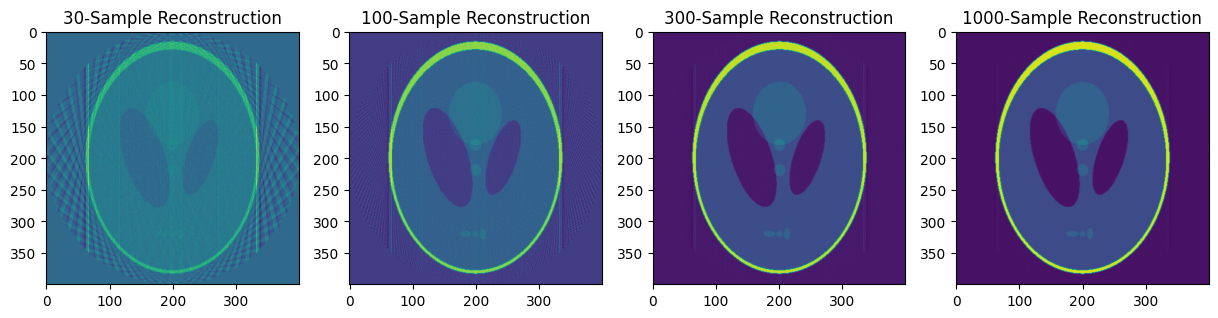

In [4]:
# TODO: Implement a method to mitigate the artifact or error
sinogram_fixed = radon(phantom, theta=np.linspace(0.0, 180.0, 1000))
reconstruction_fixed = iradon(sinogram_fixed, theta=np.linspace(0.0, 180.0, 1000), filter_name='ramp')

# TODO: Evaluate and discuss the effectiveness of your method
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15,15))

sinogram_bad = radon(phantom, theta=np.linspace(0.0, 180.0, 30))
reconstruction_bad = iradon(sinogram_bad, theta=np.linspace(0.0, 180.0, 30), filter_name='ramp')
sinogram_less_bad = radon(phantom, theta=np.linspace(0.0, 180.0, 100))
reconstruction_less_bad = iradon(sinogram_less_bad, theta=np.linspace(0.0, 180.0, 100), filter_name='ramp')

ax1.imshow(reconstruction_bad); ax1.set_title("30-Sample Reconstruction")
ax2.imshow(reconstruction_less_bad); ax2.set_title("100-Sample Reconstruction")
ax3.imshow(reconstruction); ax3.set_title("300-Sample Reconstruction")
ax4.imshow(reconstruction_fixed); ax4.set_title("1000-Sample Reconstruction")

print("Root Mean Square Error (30 Samples): ", np.sqrt(np.mean(reconstruction_bad - phantom)))
print("Root Mean Square Error (100 Samples): ", np.sqrt(np.mean(reconstruction_less_bad - phantom)))
print("Root Mean Square Error (300 Samples): ", np.sqrt(np.mean(reconstruction - phantom)))
print("Root Mean Square Error (1000 Samples): ", np.sqrt(np.mean(reconstruction_fixed - phantom)))
plt.show()

'''
As we can see, the 1000-sample reconstruction very effectively removes the artifacts from the sides of the reconstructed image, 
despite the cost of the increase root-mean-square error. This suggests yet another tradeoff in CT imaging; artifact removal compared
to introduction of what is effectively noise (and thus decreased SNR) in the image. In this case the tradeoff was worth it, because
the Gibbs-effect noise does not appear to be strongly visible in the image; in other cases this may not be the case.
Choosing a different reconstruction filter, such as one which has a high-end cutoff frequency, may assist in mitigating this tradeoff
by removing some of this Gibbs-effect noise.
'''
pass

### 2.3 CT Protocol Design & Optimization


### **Question 3**

- a) Choose a clinical goal (e.g., maximize nodule detectability, minimize dose).
- b) Optimize acquisition parameters (number of projections, rotation angles, detector size, noise level) to achieve your goal.
- c) Justify your design choices based on physical principles and clinical needs.
- d) Reflect on the trade-offs and limitations of your design.


---

## Part 3: Projection Radiography & Image Quality



### Key Concepts

- **Scatter:** Primarily due to Compton interactions; scattered photons degrade image contrast by adding unwanted background signal. Scatter increases with patient thickness and field size. (See Lecture 14)
- **Geometric Unsharpness ($U_g$):** Caused by the finite size of the X-ray source.
- **Contrast Degradation:** The scatter-to-primary ratio (SPR) quantifies the amount of scatter relative to primary photons. Higher SPR means lower contrast. Contrast degradation factor:

$$C_{degraded} = \frac{C_{ideal}}{1 + SPR}$$
- **Scatter Reduction:** Use of grids, air gaps, or collimation can reduce scatter but may increase dose or reduce signal.


### 3.1 Scatter and Contrast


### **Questions 4**

- a) Explain the physical origin of scatter in projection radiography and its impact on image contrast.

    In projection radiography, scatter originates from non-photoelectric interactions between the incident X-rays on the patient's body; generally these are either coherent (Rayleigh) or incoherent (Compton), where an incident photon is absorbed by bound electrons and then re-emitted at a different angle (and in the case of incoherent scattering, with a different energy and thus frequency). 

    Because of the stochastic nature of scattering interactions, image scatter appears as a constant 'fog' in the produced image, which reduces the image contrast based on the scatter-to-primary ratio (i.e. the intensity of scatter divided by the primary photon intensity).

- b) Describe two methods to reduce scatter and discuss their trade-offs.

    Two methods that can be used to reduce scatter include:

    * Anti-scatter grids: A series of parallel lead shutters are placed at the detector to absorb scattered photons and let parallel primary photons through; however, there are more tradeoffs to a grid compared to a collimator. The main reason for this is that an anti-scatter grid will necessarily block some primary radiation in addition to the scatter, which means that a higher dose will be required to maintain the same signal-to-noise ratio (which is largely independent of scatter).

    *  Increasing the air gap between the patient and the detector: When we adjust the object-to-image distance, non-parallel scattered radiation will miss the detector while parallel primary radiation will be captured. The main cost of this is an increase in geometric unsharpness, which corresponds to increased blue (i.e. a wider point spread function) and decreased resolution. (see Coding Exercise 4 below). In addition, increased object-to-image distance corresponds to a decrease in magnification, which can make imaging small objects more difficult.

- c) Calculate the contrast degradation factor if the scatter-to-primary ratio (SPR) is 1.5. What percent of the original contrast remains?

    $$CDF = \frac{1}{1 + 1.5}=40\%$$

    Thus, 40% of the primary contrast remains.


### **Coding Exercise 4**

1. Implement `geometric_unsharpness(f, a, b)`.
2. Plot $U_g$ as a function of $b$ for $f=1$ mm, $a=100$ cm, and $b$ from 0 to 20 cm.

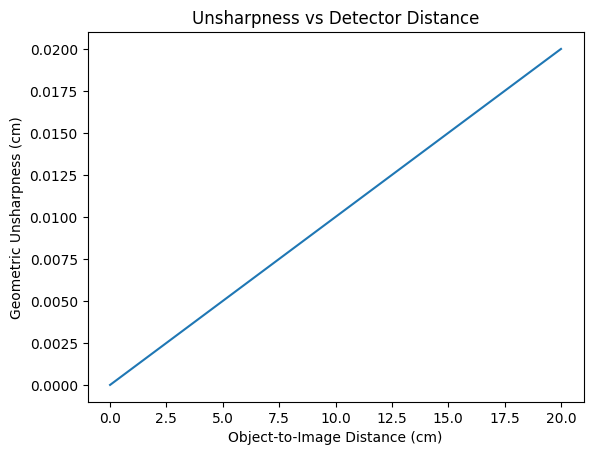

In [5]:
# TODO: Implement geometric_unsharpness(f, a, b)
def geometric_unsharpness(f, a, b):
    # In terms of the equation given in the slides:
        # f = focal spot size
        # a = source-to-object distance
        # b = object-to-image distance
    return f * (b / a)

#     ...

# TODO: Plot U_g as a function of b

d_fsd = 100; X_f = 1/10
d_oid = np.arange(0, 21)

plt.plot(d_oid, geometric_unsharpness(X_f, d_fsd, d_oid))
plt.title("Unsharpness vs Detector Distance")
plt.xlabel("Object-to-Image Distance (cm)")
plt.ylabel("Geometric Unsharpness (cm)")
plt.show()

# ...

### 3.2 Quantitative Comparison of Scatter Reduction Techniques


### **Questions 5**

- a) For each technique, calculate the percent contrast improvement using the contrast degradation formula.

    Using an anti-scatter grid with grid ratio G, we can estimate the scatter reduction to be $\frac{1}{1+G}$. Antiscatter grids reduce primary radiation as well, however; we can estimate this reduction factor to be roughly equivalent to $1-0.02G$ Putting this together, we get:

    $$SPR_{new} = SPR_{old} \times \frac{\text{scatter change coefficient}}{\text{primary change coefficient}}= SPR_{old} \times \frac{\frac{1}{1+G}}{1-0.02G}$$

    $$SPR_{new} = SPR_{old} \times \frac{1}{-0.02G^{2}+0.98G+1}$$

    Finally, we can use this to update the CDF:

    $$CDF = \frac{1}{1 + SPR} = \frac{1}{1 + SPR_{old} \times \frac{1}{-0.02G^{2}+0.98G+1}}   $$

    As an example, if we choose $G = 8$:

    $$CDF = \frac{1}{1 + 1.5 \times \frac{1}{-0.02(8^{2})+0.98(8)+1}} = \frac{1}{1 + 1.20} = 83\%  $$
    
    Using an increased air gap:
    From Figure 6.12 in the textbook (Page 142), we can see empirically how the object-to-image distance affects the scatter fraction for a given source-to-object distance. The decrease in scatter fraction produced by increasing air gap starts as a roughly linear decrease, but has diminishing returns as distance increases past roughly 35 cm; this is largely because at large air gaps, nearly all the non-parallel radiation misses the detector, and the radiation that remains is slightly attenuated by the air.

    The scatter fraction is calculated $sf = \frac{SPR}{1+SPR}$, and therefore $SPR = \frac{sf}{1-sf}$. The initial scatter fraction is $sf = \frac{1.5}{1+1.5}=0.6$. The actual change in scatter is dependent on the source-to-object distance, but based on the table we can expect a reduction of between 30% and 50% in the scatter fraction at 40 cm of air gap (where the diminishing returns begin to become apparent). Converting this to the SPR using an average decrease of 40%:

    $$sf_{new} = 0.6 \times 0.6 = 0.36 $$

    $$SPR_{new} = \frac{0.36}{1-0.36} = 0.5625 $$

    $$CDF = \frac{1}{1 + 0.5625} = 64\% $$


- b) Summarize your findings: Which technique is most effective? What are the trade-offs (e.g., dose, practicality, image artifacts)?

    The use of an anti-scatter grid is clearly superior to that of an increased air gap. Not only is its CDF higher, indicating that more of the primary contrast will be visible at the readout, but its benefits do not taper off as easily. The tradeoff in this case is an increased dose requirement from the Bucky Factor for the anti-scatter grid. For the air gap, the primary trade-off is an increase in blur and consequent decrease in system resolution. 

### 3.3 Simulating Scatter Effects and Grid Optimization

### **Coding Exercise 5**

In this exercise, you will simulate the effect of scatter on a simple X-ray image and explore how grid design can optimize image contrast.

**Scenario:**
You are given a 1D 'image' (e.g., a step function representing an object) and must model the effect of scatter as an additive background proportional to the primary signal. You will then simulate the use of an anti-scatter grid with variable grid ratio to reduce scatter, and determine the optimal grid ratio for maximizing contrast while considering signal loss.

**Tasks:**
1. Simulate the effect of scatter on a simple 1D object (e.g., a step function) by adding a scatter component proportional to the primary signal using the fixed SPR value.
2. Model the impact of an anti-scatter grid: for each grid ratio $G$, reduce scatter by $1/(1+G)$ and primary signal by $T_p$ (e.g., $T_p = 1 - 0.02 \times G$).
3. Plot image contrast as a function of grid ratio for the fixed SPR, and identify the grid ratio that maximizes contrast. 

**Hints:**
- Use matplotlib for plotting.
- You may assume a fixed SPR value (e.g., SPR = 1.5).
- You may define contrast as $(I_{max} - I_{min})/(I_{max} + I_{min})$ for the detected signal.
- You may use a simple linear model for $T_p(G)$, e.g., $T_p = 1 - 0.02 	\times G$ (for $G$ from 0 to 12).

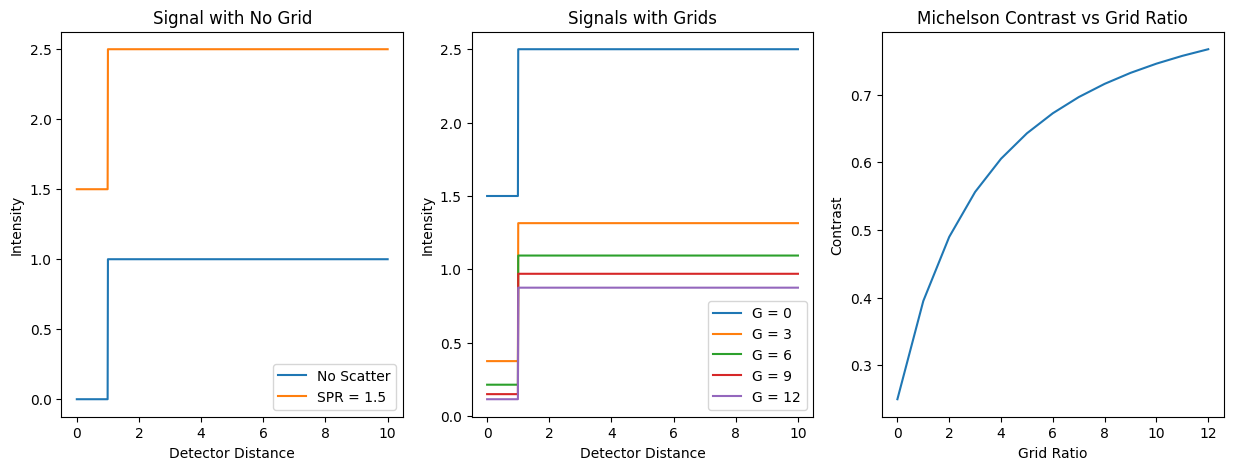

In [ ]:
# TODO: Simulate scatter and grid optimization for a 1D image

def scatter_and_grid_ratio(primary, original_SPR, grid_ratio):
    scatter_reduction = 1 / (1 + grid_ratio)
    primary_reduction = 1 - 0.02*grid_ratio

    original_scatter = original_SPR * max(primary)
    return [(y * primary_reduction) + (scatter_reduction * original_scatter) for y in primary]

SPR_initial = 1.5   
x = np.linspace(0, 10, num=1000)
signal = [float(x >= 1) for x in np.linspace(0, 10, num=1000)]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.plot(x, signal, x, scatter_and_grid_ratio(signal, SPR_initial, 0)) # grid ratio 0 = no grid
ax1.set_ylabel("Intensity"); ax1.set_xlabel("Detector Distance"); ax1.set_title("Signal with No Grid")
ax1.legend(["No Scatter", "SPR = 1.5"])

# TODO: Plot and analyze the effect of grid ratio on contrast

grid_ratios = range(13)

def contrast(input_signal):
    return (max(input_signal) - min(input_signal)) / (max(input_signal) + min(input_signal))

contrasts = [contrast(scatter_and_grid_ratio(signal, SPR_initial, G)) for G in grid_ratios]

ax2.plot(x, scatter_and_grid_ratio(signal, SPR_initial, 0),
         x, scatter_and_grid_ratio(signal, SPR_initial, 3), 
         x, scatter_and_grid_ratio(signal, SPR_initial, 6), 
         x, scatter_and_grid_ratio(signal, SPR_initial, 9),
         x, scatter_and_grid_ratio(signal, SPR_initial, 12))
ax2.set_ylabel("Intensity"); ax2.set_xlabel("Detector Distance"); ax2.set_title("Signals with Grids")
ax2.legend(["G = 0", "G = 3", "G = 6", "G = 9", "G = 12"])

ax3.plot(grid_ratios, contrasts)
ax3.set_xlabel("Grid Ratio"); ax3.set_ylabel("Contrast")
ax3.set_title("Michelson Contrast vs Grid Ratio")

plt.show()

# TODO: Discuss your findings and trade-offs
'''
As we can see, the absolute contrast present in the image improves with a larger grid ratio; however,
this improvement comes with diminishing returns as the grid ratio continues to increase.
This is for two reasons: first, at large grid ratios, the majority of the non-parallel scattered radiation
has already been blocked by the grid, and second, large grid ratios begin to attenuate the primary signal
significantly as well. Since scatter shows as a roughly-uniform 'fog' in the image, we want to remove as much
of the scatter as possible while keeping the primary signal intact in order to get rid of the 'fog' and improve
the image contrast and thus detectability of features. Thus, selection of a grid ratio should balance the 
tradeoffs between attenuating scatter and attenuating primary radiation in order to achieve acceptable contrast.
'''
pass

---

## Part 4: X-ray Detectors & Quantum Efficiency



### Key Concepts

- **Quantum Efficiency (QE):** The fraction of incident X-ray photons detected and converted to signal. Higher QE improves SNR and allows for lower patient dose.

$$QE = \frac{\text{Detected photons}}{\text{Incident photons}}$$
- **Detective Quantum Efficiency (DQE):** Describes how well a detector preserves SNR across spatial frequencies.

$$DQE(f) = \frac{(SNR_{out}(f))^2}{(SNR_{in}(f))^2}$$
- **Readout Noise:** Electronic noise added during signal readout; becomes significant at low doses or for low-signal regions.
- **Detector Types:** Indirect (scintillator + photodiode) and direct (photoconductor) detectors have different QE and noise characteristics.


### 4.1 Detector Selection Scenario

### **Questions 6**

You are comparing two digital X-ray detectors for a trauma imaging suite:

   1. Detector A: High quantum efficiency (QE), moderate readout noise
   2. Detector B: Lower QE, but very low readout noise

- a) Define quantum efficiency and explain its importance for image quality and dose.

   Detective Quantum Efficiency is formally defined as the square of the output SNR divided by the square of the input SNR. It ranges between 0 and 1, because the output SNR can never exceed the input SNR. In practice, DQE represents the dose efficiency of the system; a system with a given DQE produces output images with the same SNR as a hypothetical system that has perfect efficiency but receives only a fraction of input photons equal to the DQE. (For instance, a system with DQE = 80% will have the same SNR output as a system with 100% DQE receiving 80% of the input photon intensity.) Thus, a system with better DQE requires less dosage to produce the same quality of image.

- b) Discuss the trade-offs between quantum efficiency and readout noise for low-dose imaging.

   DQE is a measure of how much noise the imaging system introduces to the original image; at the same dose, systems with poor DQE will thus experience lower SNR than systems with good DQE. It is important to note, however, that detectors with different DQE can never improve the SNR from the input image.
   Meanwhile, electronic readout noise is introduced by the system, degrading the SNR. Poor DQE could involve a high degree of readout noise, reducing the SNR significantly, while readout noise in a large-DQE system will not affect the image significanrly.

- c) Which detector would you recommend for pediatric trauma imaging and why?

   Pediatric imaging has low doses as a prerequisite; thus, we should choose the imaging system that allows for good imaging with as small a dose as possible (considering the ALARA principle). Since readout noise decreases SNR, it must be accounted for in the DQE calculation. Detector B looks promising due to its very low readout noise, but its DQE is lower than Detector A, meaning that it requires higher doses to produce the same quality of image. Meanwhile, Detector A's readout noise is higher, but its DQE is also higher, meaning that it preserves the SNR better despite its higher readout noise and thus allows for lower-dose imaging; exactly what we need in a pediatric imaging system. Thus, I would select Detector A.


### **Coding Exercise 6**

1. Modify the code to add a third detector (Detector C) with your own parameters for SNR_out_C.
2. Plot and compare the DQE for all three detectors.
3. Briefly discuss how your changes affect the DQE curves.

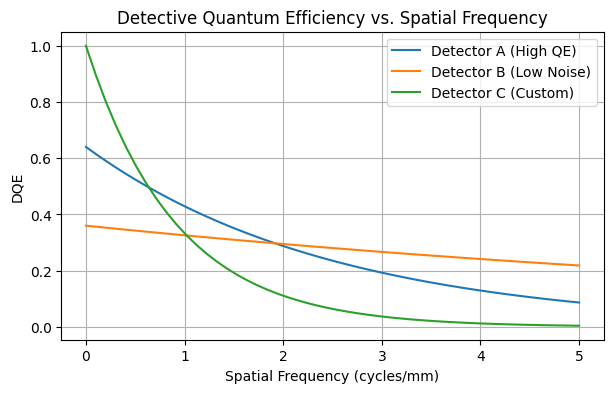

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def compute_dqe(snr_in, snr_out):
    return (snr_out ** 2) / (snr_in ** 2)

# Example data for two detectors
spatial_freq = np.linspace(0, 5, 50)  # cycles/mm
snr_in = 100 * np.exp(-0.2 * spatial_freq)
snr_out_A = 80 * np.exp(-0.4 * spatial_freq)  # High QE, moderate noise
snr_out_B = 60 * np.exp(-0.25 * spatial_freq)  # Lower QE, low noise
snr_out_C = 100 * np.exp(-0.75 * spatial_freq)  # Custom

dqe_A = compute_dqe(snr_in, snr_out_A)
dqe_B = compute_dqe(snr_in, snr_out_B)
dqe_C = compute_dqe(snr_in, snr_out_C)

plt.figure(figsize=(7,4))
plt.plot(spatial_freq, dqe_A, label='Detector A (High QE)')
plt.plot(spatial_freq, dqe_B, label='Detector B (Low Noise)')
plt.plot(spatial_freq, dqe_C, label='Detector C (Custom)')
plt.xlabel('Spatial Frequency (cycles/mm)')
plt.ylabel('DQE')
plt.title('Detective Quantum Efficiency vs. Spatial Frequency')
plt.legend()
plt.grid(True)
plt.show()

# TODO: Briefly discuss how your changes affect the DQE curves.


### **Coding Exercise 7**

1. Display the original image.
2. Apply contrast enhancement.
3. Apply brightness adjustment.
4. Display the adjusted images side-by-side.
5. Discuss how these changes affect image quality and visibility of features.

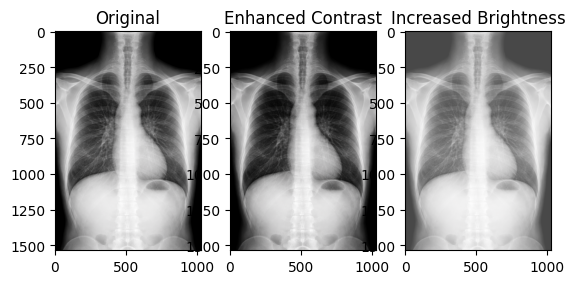

In [8]:
#USE IMAGE 'Xray_Chest.png'
import matplotlib.image as mpimg
original = mpimg.imread('data/Xray_Chest.png')

# TODO: Apply contrast enhancement
gamma = 1.4
contrast_enhanced = [pixel**gamma for pixel in original]

# TODO: Apply brightness adjustment
brightness_adjusted = [(pixel + 0.4)/1.4 for pixel in original]
    # divide by 1.4 to prevent input clipping when value > 1

# TODO: Display the original and adjusted images
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.imshow(original); ax1.set_title("Original")
ax2.imshow(contrast_enhanced); ax2.set_title("Enhanced Contrast")
ax3.imshow(brightness_adjusted); ax3.set_title("Increased Brightness")

# TODO: Discuss the effects below
'''
Adjusting the image contrast makes bright parts brighter and/or dark parts darker. It allows for 
improved identification of regions with slightly differing intensity values from each other.
(note how the spine is easier to distinguish in the abdominal region following contrast adjustment)
Adjusting the image brightness makes everything uniformly brighter or darker, 
effectively simulating adding a uniform 'fog' to the image not unlike that caused by scatter.
'''
pass

---

## Part 5: Computed Tomography (CT) Principles & Image Reconstruction



### Key Concepts

- **Hounsfield Units (HU):** Quantifies tissue attenuation relative to water.

$$HU = 1000 \cdot \frac{\mu_{tissue} - \mu_{water}}{\mu_{water}}$$
- **CT Projections:** Each projection is a line integral of attenuation coefficients along a path through the object:

$$P(\theta, t) = \int \mu(x, y) ds$$
- **Sinogram:** A 2D plot of projection data as a function of angle and position; each point in the object traces a sinusoidal path in the sinogram.
- **Image Reconstruction:** Filtered backprojection and iterative methods reconstruct the 2D image from projections.


### 5.1 Hounsfield Units and Tissue Contrast


### **Questions 7**

- a)  Define the Hounsfield unit and explain how it is calculated from measured attenuation coefficients.

    1 HU is defined as 0.1% of the attenuation coefficient of water. It is calculated based on the relative difference in attenuation coefficients between a substance and water, multiplied by 1000 to provide high low-contrast resolution. It is calculated using the formula:

    $$HU = 1000 \cdot \frac{\mu_{substance} - \mu_{water}}{\mu_{water}}$$

- b) Calculate the HU for a tissue with:

$$
\mu_{\text{tissue}} = 0.22\ \text{cm}^{-1}, \quad
\mu_{\text{water}} = 0.20\ \text{cm}^{-1}, \quad
\mu_{\text{air}} = 0.0002\ \text{cm}^{-1}
$$

Show your calculation step by step.

$$HU = 1000 \cdot \frac{0.22 - 0.20}{0.20} = 1000 \cdot \frac{0.02}{0.20}= 1000 \cdot 0.1=100 \text{ HU}$$

- c) Discuss the clinical significance of HU values in CT imaging.

    In CT imaging, HU values represent the attenuation of a linear X-ray beam through a given voxel (3D pixel) in the patient's body. By taking multiple measurements at different angles, the HU value for each voxel can be identified and compared to tables to identify the specific tissue or substance that occupies that voxel.

### **Coding Exercise 8**

1. Create a 2D numpy array representing a phantom with a circular region of higher attenuation.
2. Simulate the projection (sum of attenuation) at a given angle.
3. Plot the phantom and its projection profile.

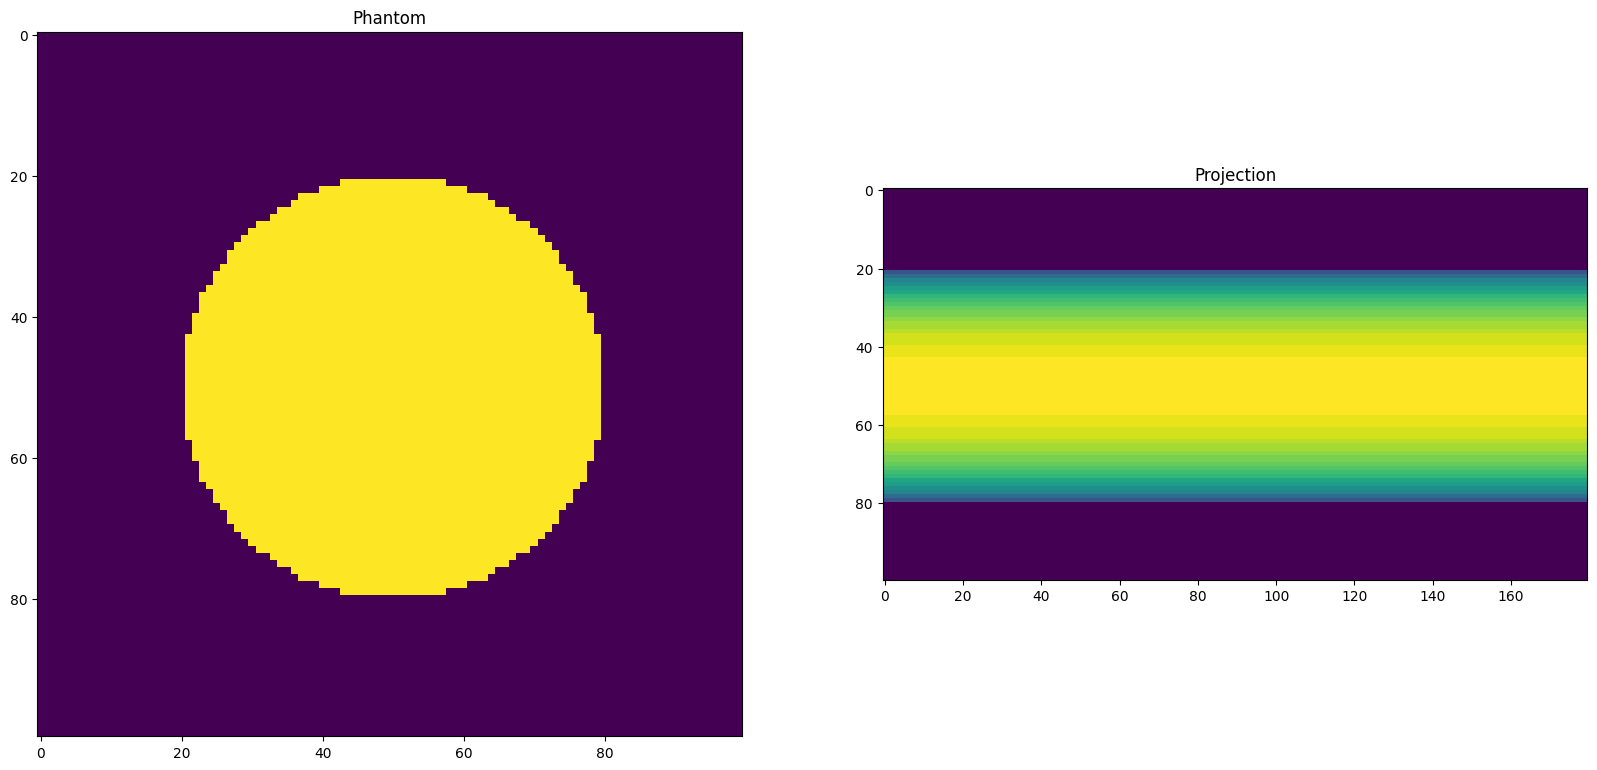

In [9]:
# TODO: Create a 2D numpy array phantom with a circular region
radius = 30; centre = (50, 50)
phantom = np.zeros((100, 100))
for x, row in enumerate(phantom):
    for y, pixel in enumerate(row):
        # Equation of a circle's inner region: s(x - x0)**2 + (y - y0)**2 < r**2
        if (np.sqrt((x - centre[0])**2 + (y - centre[1])**2) < radius):
            phantom[x][y] = 1

# TODO: Simulate the projection (sum of attenuation) at a given angle
row_sums = []
for x, row in enumerate(phantom):
    # Start at angle 0, summing the attenuation of each row
    row_sums.append(np.sum(row))

# Because a circle is symmetrical, the projection will be the same at every angle
# Thus, we can copy this data 180 times (360/2) to get the full slice sinogram
projection = np.transpose([row_sums]*180)

# If this wasn't symmetrical, we would have to:
    # Transpose the image so that it is centred at (0, 0)
    # Multiply each coordinate in the image by a 2x2 rotation matrix, dependent on the angle
    # Then transpose it back and do the same sum across each row

# TODO: Plot the phantom and its projection profile
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 20))
ax1.imshow(phantom); ax1.set_title("Phantom")
ax2.imshow(projection); ax2.set_title("Projection")
plt.show()


---

## Part 6: CT Image Quality, Artifacts, and Dose Optimization



### Key Concepts

- **Streak Artifacts:** Appear as bright/dark lines, often caused by high-attenuation objects (metal), beam hardening (lower energy photons absorbed more), or photon starvation (very low signal).
- **Noise:** In CT, noise is primarily quantum (photon) noise and is inversely proportional to the square root of dose:

$$\sigma = \frac{K}{\sqrt{D}}$$
- **Dose Optimization:** The goal is to minimize patient dose while maintaining diagnostic image quality. Techniques include automatic exposure control and iterative reconstruction.


### 6.1 CT Streak Artifact Analysis

### **Questions 8**

- a) Carefully examine the artifact in the image. Describe the physical and mathematical causes of streak artifacts in CT (reference concepts such as beam hardening, photon starvation, and reconstruction errors).
- b) Propose and explain at least two algorithmic or acquisition-based strategies to reduce or mitigate streak artifacts in clinical CT.


### **Coding Exercise 9**

1. Write a function `ct_noise_vs_dose(D, K)`.
2. Plot image noise as a function of dose for $K=10$ and $D$ from 1 to 100 (arbitrary units).

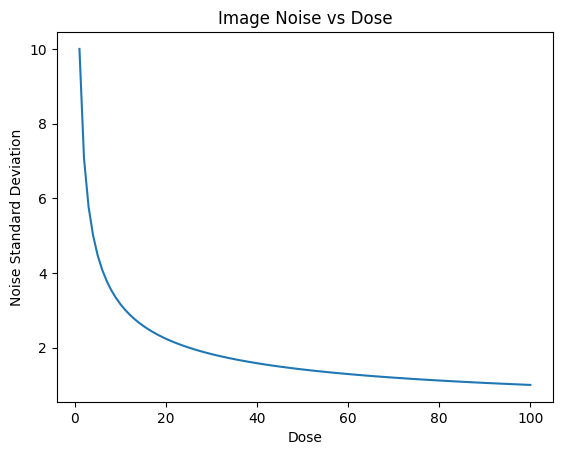

'\nThe noise-dose relationship in CT appears as a decaying exponential. \nThis means that the same increase in dose has a large impact on noise the first time, \nbut progressively smaller impacts on image noise with every subseqauent increase\n(diminishing returns). \n'

In [10]:
# USE IMAGE 'Brain_CT.png'

# TODO: Write a function ct_noise_vs_dose(D, K)
def ct_noise_vs_dose(D, K):
    return K / np.sqrt(D)
#     ...

# TODO: Plot image noise as a function of dose
D = np.arange(1, 101); K = 10
plt.plot(D, ct_noise_vs_dose(D, K))
plt.xlabel("Dose"); plt.ylabel("Noise Standard Deviation")
plt.title("Image Noise vs Dose")
plt.show()

# TODO: Analyze and discuss the results

'''
The noise-dose relationship in CT appears as a decaying exponential. 
This means that the same increase in dose has a large impact on noise the first time, 
but progressively smaller impacts on image noise with every subseqauent increase
(diminishing returns). 
'''

---

## Part 7: Quantitative Analysis of CT Image Quality

### Key Concepts

- **SNR (Signal-to-Noise Ratio):**

$$\mathrm{SNR} = \frac{\mu_{signal}}{\sigma_{noise}}$$
- **RMSE (Root Mean Square Error):** Measures the average difference between two images:

$$RMSE = \sqrt{\frac{1}{N} \sum_{i=1}^N (I_i - I_{ref,i})^2}$$
- **Filtering:** Denoising filters (Gaussian, median, bilateral) can reduce noise but may blur edges or reduce detail.


### 7.1 SNR and RMSE Analysis


### **Coding Exercise 10**

1. Apply a denoising or edge-preserving filter of your choice (e.g., Gaussian, median, or bilateral filter).
2. Compute and compare the following metrics before and after filtering:
   - Signal-to-Noise Ratio (SNR)
   - Root Mean Square Error (RMSE)
   (You may use the original image as reference for RMSE, or compare to a region of interest.)
3. Discuss what these metrics reveal about image quality and the impact of filtering.

SNR Before Filtering: 0.8268711
SNR After Filtering: 0.8665659
RMSE Before Filtering: 0
RMSE After Filtering: 0.06339257


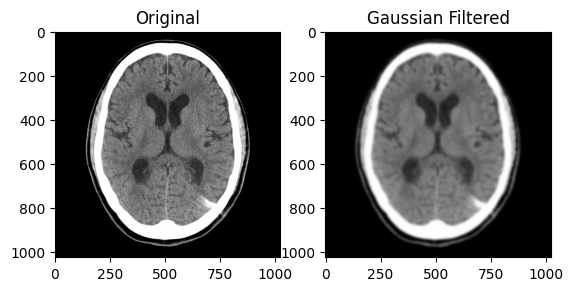

In [11]:
# USE IMAGE 'Brain_CT.png'
img = mpimg.imread('data/Brain_CT.png')

# TODO: Apply a filter to img (e.g., Gaussian, median, etc.)
from scipy.ndimage import gaussian_filter
filtered_img = gaussian_filter(img, sigma=5)

# TODO: Compute SNR and RMSE before and after filtering
snr_before = np.mean(img) / np.std(img) # SNR = mean / std (from formula sheet)
snr_after = np.mean(filtered_img) / np.std(filtered_img)
print("SNR Before Filtering:", snr_before)
print("SNR After Filtering:", snr_after)

rmse_before = 0 # The image is exactly equal to itself
rmse_after = np.sqrt(np.mean((filtered_img - img)**2))
print("RMSE Before Filtering:", rmse_before)
print("RMSE After Filtering:", rmse_after)

# TODO: Visualize the original and filtered images
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(img); ax1.set_title("Original")
ax2.imshow(filtered_img); ax2.set_title("Gaussian Filtered")
plt.show()

'''
As we can see, Gaussian filtering improves the signal-to-noise ratio of the image by smoothing noise.
The cost of this, however, is that it introduces some error into the image which was not present before.
In practice, a smoothing filter like this widens the point spread function, thus reducing resolution.
Thus, image filtering provides a tradeoff between resolution and SNR.
'''
pass

---

## **<u>Submission Requirements</u>**

**You must submit TWO files to D2L:**

1. **Jupyter Notebook** (`.ipynb`): Your completed notebook with all code, outputs, and written analysis. All cells must be executed in order.

2. **PDF Export** (`.pdf`): Export your notebook to PDF (File → Export as PDF, or print to PDF). Verify all figures and equations render correctly.

**Important:** All answers must be completed directly in this Jupyter notebook.

**File naming convention:** `LastName_FirstName_Deliverable2.ipynb` and `.pdf`

**Due:** Monday, March 2, 2026 at 11:59 PM

---

## Submission Summary

| Section | Questions/Analysis Due |
|---------|------------------------|
| **Part 1: X-ray Production & Spectrum** | Q1 (a,b,c), Coding Exercise 1 |
| **Part 2: CT Simulation, Error Analysis & Design** | Coding Exercise 2, Q2 (a,b,c), Coding Exercise 3, Q3 (a,b,c,d)  |
| **Part 3: Projection Radiography & Image Quality** | Q4 (a,b,c), Coding Exercise 4, Q5 (a,b), Coding Exercise 5 |
| **Part 4: X-ray Detectors & Quantum Efficiency** | Q6 (a,b,c), Coding Exercise 6, Coding Exercise 7|
| **Part 5: CT Principles & Image Reconstruction** | Q7 (a,b,c), Coding Exercise 8|
| **Part 6: CT Image Quality, Artifacts & Dose Optimization** | Q8 (a,b), Coding Exercise 9 |
| **Part 7: Quantitative Analysis of CT Image Quality** | Coding Exercise 10 |
